In [34]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.layers import LSTM, Convolution1D, Flatten, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional, GlobalMaxPool1D,Conv1D
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.models import Model
import re
from pandas_ml import ConfusionMatrix
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

# Data Read-in & Preprocessing

## only import the columns: "stars" and "text"

In [2]:
path = "/Users/kia/Desktop/SYS 6016/Final project/"
file = "yelp_review.csv"
df = pd.read_csv(path+file,usecols = ["stars","text"])
df.shape

(5261668, 2)

## check if there's any missing values

In [3]:
df.isnull().sum()

stars    0
text     0
dtype: int64

## plot the histogram for stars

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



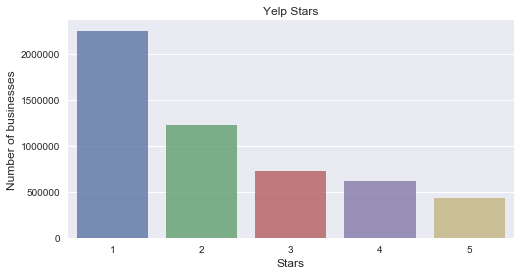

In [9]:
x = df['stars'].value_counts()
y = x.sort_index()

plt.figure(figsize=(8,4))
ax= sns.barplot(y.index, x.values, alpha=0.8)
plt.title("Yelp Stars")
plt.ylabel('Number of businesses', fontsize=12)
plt.xlabel('Stars', fontsize=12)

## Create a binary label

* 4 & 5 = positive
* 1 & 2 = negative
* Remove 3 since it is neutral
* label 1: positive
* label 0: negative

In [10]:
df = df[df['stars']!=3]

In [11]:
df["label"] = df["stars"].apply(lambda x: 1 if x > 3  else 0)
label_df = df.drop("stars",axis=1)

label_df.head()

,text,label
0,Super simple place but amazing nonetheless. It...,1
1,Small unassuming place that changes their menu...,1
2,Lester's is located in a beautiful neighborhoo...,1
3,Love coming here. Yes the place always needs t...,1
4,Had their chocolate almond croissant and it wa...,1


In [12]:
label_df['label'].value_counts()

1    3476663
0    1169524
Name: label, dtype: int64

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



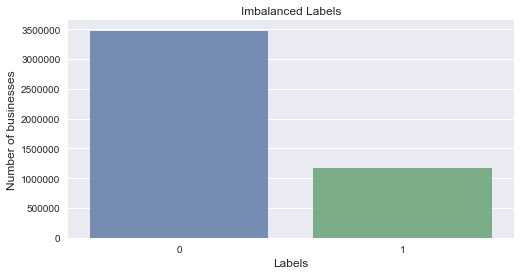

In [13]:
x = label_df['label'].value_counts()
y = x.sort_index()

plt.figure(figsize=(8,4))
ax= sns.barplot(y.index, x.values, alpha=0.8)
plt.title("Imbalanced Labels")
plt.ylabel('Number of businesses', fontsize=12)
plt.xlabel('Labels', fontsize=12)
plt.savefig('Imbalanced labels.png')

## Downsample to the minority class with ratio 1:1
* Due to limited computing power, we took a random sample of 100,000 reviews.

In [14]:
balance_df = label_df.groupby('label')
subset_df = balance_df.apply(lambda x: x.sample(50000,random_state=42).reset_index(drop=True))
subset_df['label'].value_counts()

1    50000
0    50000
Name: label, dtype: int64

## Tokenize the text

In [15]:
text = subset_df["text"].values
label = subset_df["label"].values

In [16]:
MAX_NUM_WORDS=2500 # num of rows in embedding vector
MAX_SEQUENCE_LENGTH=100 # max number of words in a review to use


tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

sequence_encodings = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

label = keras.utils.to_categorical(np.asarray(label))
print('Shape of sequence encodings tensor:', sequence_encodings.shape)
print('Shape of label tensor:', label.shape)

Found 98098 unique tokens.
Shape of sequence encodings tensor: (100000, 100)
Shape of label tensor: (100000, 2)


# Split data into training and testing

In [17]:
VALIDATION_SPLIT=0.2

indices = np.arange(sequence_encodings.shape[0])
np.random.shuffle(indices)
sequence_encodings = sequence_encodings[indices]
label = label[indices]
nb_validation_samples = int(VALIDATION_SPLIT * sequence_encodings.shape[0])

trainX = sequence_encodings[:-nb_validation_samples]
trainY = label[:-nb_validation_samples]
testX = sequence_encodings[-nb_validation_samples:]
testY = label[-nb_validation_samples:]

# LSTM

## LSTM with a Keras Embedding layer that learns 

In [18]:
embed_dim = 100 #size of the embedding vectors
lstm_out = 200

model_lstm = Sequential()
model_lstm.add(Embedding(2500, embed_dim, input_length=sequence_encodings.shape[1]))
model_lstm.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
model_lstm.add(Dense(2,activation='sigmoid'))
model_lstm.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_lstm.summary())

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning:

Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          250000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 491,202
Trainable params: 491,202
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
model_lstm.fit(trainX, trainY, validation_data=(testX, testY),
          epochs=3, batch_size=128)

Train on 80000 samples, validate on 20000 samples
Epoch 1/3
80000/80000 [==============================] - 299s 4ms/step - loss: 0.2847 - acc: 0.8826 - val_loss: 0.2206 - val_acc: 0.9143
Epoch 2/3
80000/80000 [==============================] - 322s 4ms/step - loss: 0.2024 - acc: 0.9224 - val_loss: 0.1827 - val_acc: 0.9293
Epoch 3/3
80000/80000 [==============================] - 346s 4ms/step - loss: 0.1778 - acc: 0.9314 - val_loss: 0.1837 - val_acc: 0.9304


,precision,recall,F1_score,support
Classes,,,,
False,0.94237,0.918513,0.930288,10112
True,0.91877,0.942557,0.930511,9888
__avg / total__,0.930702,0.9304,0.930399,20000


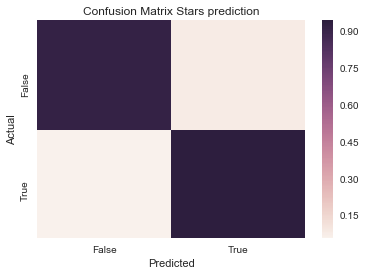

In [22]:
y_true =  testY.argmax(axis=1)
preds = model_lstm.predict_classes(testX)
cm = ConfusionMatrix(y_true, preds)
cm.classification_report
cm.plot(backend='seaborn', normalized=True)
plt.title('Confusion Matrix Stars prediction')
plt.figure(figsize=(12, 10))
cm.classification_report

## Adding a Conv 1-D layer to the above LSTM (with embedding layer)

In [23]:
model_conv = Sequential()
model_conv.add(Embedding(2500, embed_dim, input_length=sequence_encodings.shape[1]))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
model_conv.add(Dense(2,activation='sigmoid'))
model_conv.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_conv.summary())

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning:

Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          250000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 64)            32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               212000    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 494,466
Trainable params: 494,466
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
model_conv.fit(trainX, trainY, validation_data=(testX, testY),
          epochs=3, batch_size=128)

Train on 80000 samples, validate on 20000 samples
Epoch 1/3
80000/80000 [==============================] - 118s 1ms/step - loss: 0.2373 - acc: 0.8985 - val_loss: 0.1647 - val_acc: 0.9344
Epoch 2/3
80000/80000 [==============================] - 112s 1ms/step - loss: 0.1580 - acc: 0.9383 - val_loss: 0.1562 - val_acc: 0.9390
Epoch 3/3
80000/80000 [==============================] - 115s 1ms/step - loss: 0.1350 - acc: 0.9487 - val_loss: 0.1557 - val_acc: 0.9401


,precision,recall,F1_score,support
Classes,,,,
False,0.935424,0.946895,0.941124,10112
True,0.945002,0.933151,0.939039,9888
__avg / total__,0.940159,0.9401,0.940094,20000


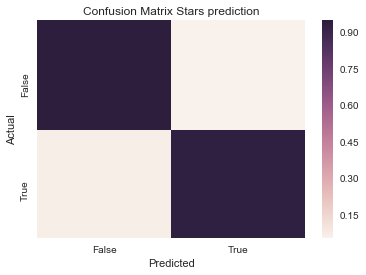

In [25]:
preds = model_conv.predict_classes(testX)
cm = ConfusionMatrix(y_true, preds)
cm.plot(backend='seaborn', normalized=True)
plt.title('Confusion Matrix Stars prediction')
plt.figure(figsize=(12, 10))
cm.classification_report

## Use a pre-trained word embedding from Glove
* This is the exact same model from above except we used Glove embeddings instead of a keras embedding layer

In [26]:
path='/Users/kia/Desktop/SYS 6016/Final project/glove.6B/'

import os
embeddings_index = {}
f = open(os.path.join(path, 'glove.6B.100d.txt'),encoding ='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


In [27]:
EMBEDDING_DIM = 100 # how big is each word vector

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [28]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [31]:
model_glove = Sequential()
model_glove.add(embedding_layer)
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(200))
model_glove.add(Dense(2, activation='sigmoid'))
model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_glove.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          9809900   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 96, 64)            32064     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               212000    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 402       
Total params: 10,054,366
Trainable params: 244,466
Non-trainable params: 9,809,900
___________________________________________________________

In [32]:
model_glove.fit(trainX, trainY, validation_data=(testX, testY),
          epochs=3, batch_size=128)

Train on 80000 samples, validate on 20000 samples
Epoch 1/3
80000/80000 [==============================] - 100s 1ms/step - loss: 0.3748 - acc: 0.8260 - val_loss: 0.2684 - val_acc: 0.8862
Epoch 2/3
80000/80000 [==============================] - 100s 1ms/step - loss: 0.2592 - acc: 0.8914 - val_loss: 0.2575 - val_acc: 0.8893
Epoch 3/3
80000/80000 [==============================] - 104s 1ms/step - loss: 0.2335 - acc: 0.9024 - val_loss: 0.2079 - val_acc: 0.9160


,precision,recall,F1_score,support
Classes,,,,
False,0.918171,0.915447,0.916807,10112
True,0.913793,0.916566,0.915177,9888
__avg / total__,0.916007,0.916,0.916001,20000


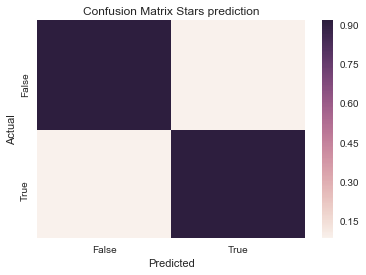

In [33]:
preds = model_glove.predict_classes(testX)
cm = ConfusionMatrix(y_true, preds)
cm.plot(backend='seaborn', normalized=True)
plt.title('Confusion Matrix Stars prediction')
plt.figure(figsize=(12, 10))
cm.classification_report

# TNSE

## Note: plotly needs to be installed to see the visuals

In [35]:
lstm_embds = model_lstm.layers[0].get_weights()[0]
conv_embds = model_conv.layers[0].get_weights()[0]

In [36]:
word_list = []
for word, i in tokenizer.word_index.items():
    word_list.append(word)

In [37]:
def plot_words(data, start, stop, step):
    trace = go.Scatter(
        x = data[start:stop:step,0], 
        y = data[start:stop:step, 1],
        mode = 'markers',
        text= word_list[start:stop:step]
    )
    layout = dict(title= 't-SNE 1 vs t-SNE 2',
                  yaxis = dict(title='t-SNE 2'),
                  xaxis = dict(title='t-SNE 1'),
                  hovermode= 'closest')
    fig = dict(data = [trace], layout= layout)
    py.iplot(fig)

In [38]:
lstm_tsne_embds = TSNE(n_components=2).fit_transform(lstm_embds)

In [39]:
plot_words(lstm_tsne_embds, 0, 2000, 1)

In [40]:
conv_tsne_embds = TSNE(n_components=2).fit_transform(conv_embds)

In [41]:
plot_words(conv_tsne_embds, 0, 2000, 1)

Resources: 
* keras official documentation: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
* Nimesh Sinha: https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47 
* Ahamed's github repo: https://github.com/msahamed/